<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning-UAS/blob/main/Chapter_11_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Persiapan

In [1]:
# Setup lingkungan
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# TensorBoard
try:
    %load_ext tensorboard
except:
    pass

# Library umum
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

# Konfigurasi
np.random.seed(42)
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Lokasi penyimpanan gambar
IMAGES_PATH = os.path.join(".", "images", "deep")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem dan Xavier and He Initialization

Saving figure sigmoid_saturation_plot


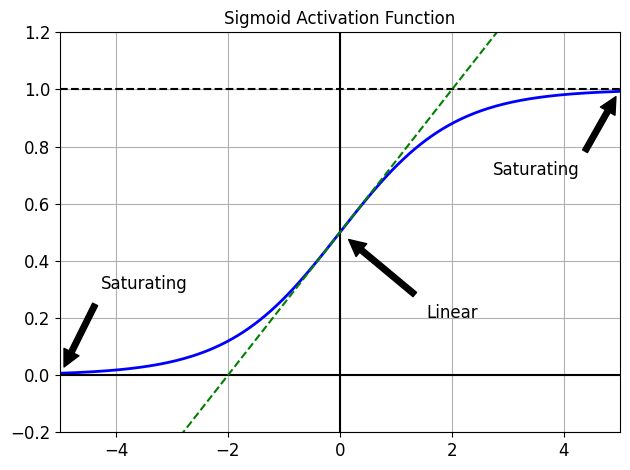

In [2]:
# Fungsi aktivasi sigmoid
def logit(z):
    return 1 / (1 + np.exp(-z))

# Plot sigmoid
z = np.linspace(-5, 5, 200)
plt.plot(z, logit(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

# Anotasi
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=12, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=12, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=12, ha="center")

plt.title("Sigmoid Activation Function")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("sigmoid_saturation_plot")
plt.show()

In [3]:
# Lihat semua inisialisasi bawaan
[k for k in dir(keras.initializers) if not k.startswith("_")]

# Dense layer dengan inisialisasi He normal
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

# Alternatif: Variance Scaling (setara dengan He atau Glorot tergantung parameternya)
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<Dense name=dense_1, built=False>

## Nonsaturating Activation Functions

### Leaky ReLU

Saving figure leaky_relu_plot


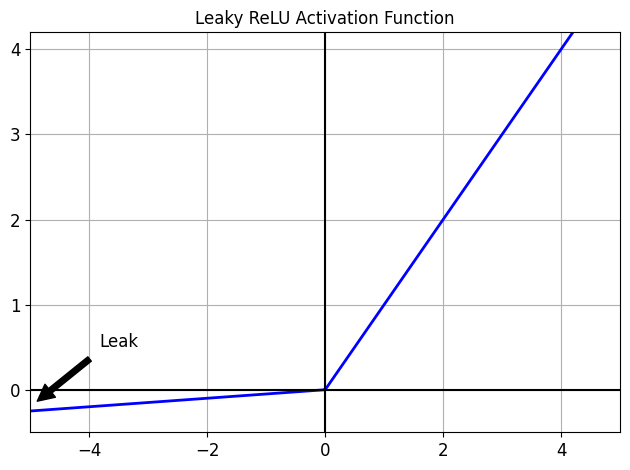

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [4]:
# Fungsi Leaky ReLU dan plotnya
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=12, ha="center")
plt.title("Leaky ReLU Activation Function")
plt.axis([-5, 5, -0.5, 4.2])
save_fig("leaky_relu_plot")
plt.show()

# Aktivasi dan Layer yang berkaitan dengan ReLU
[act for act in dir(keras.activations) if not act.startswith("_")]
[layer for layer in dir(keras.layers) if "relu" in layer.lower()]

In [5]:
# Load & preprocessing data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Set seed
tf.random.set_seed(42)
np.random.seed(42)

# Membangun model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

# Compile & fit
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4644 - loss: 1.6498 - val_accuracy: 0.7230 - val_loss: 0.8658
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7276 - loss: 0.8277 - val_accuracy: 0.7680 - val_loss: 0.7077
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7695 - loss: 0.6987 - val_accuracy: 0.7948 - val_loss: 0.6356
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7907 - loss: 0.6336 - val_accuracy: 0.8086 - val_loss: 0.5911
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8027 - loss: 0.5920 - val_accuracy: 0.8178 - val_loss: 0.5604
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8121 - loss: 0.5627 - val_accuracy: 0.8268 - val_loss: 0.5377
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8190 - loss: 0.5407 - val_accuracy: 0.8310 - val_loss: 0.5200
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8241 - loss: 0.5233

=== Ringkasan Metrik ===
accuracy: 0.8308
val_accuracy: 0.8418
loss: 0.4981
val_loss: 0.4839


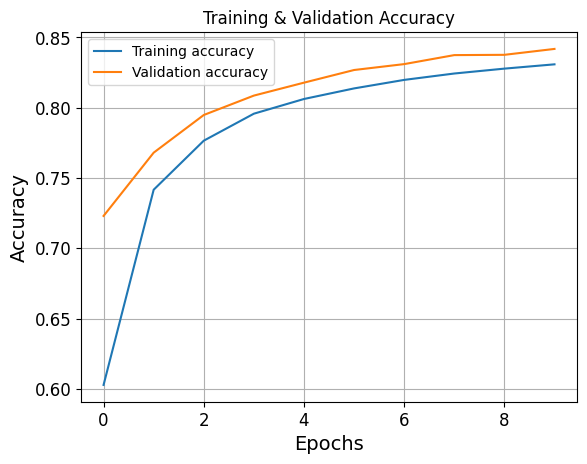

In [6]:
# Ekstrak hasil pelatihan
history_dict = history.history

print("=== Ringkasan Metrik ===")
for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
    print(f"{key}: {history_dict[key][-1]:.4f}")

# Plot Akurasi
plt.plot(history_dict['accuracy'], label='Training accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### PReLU

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4431 - loss: 1.7584 - val_accuracy: 0.7170 - val_loss: 0.9294
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7228 - loss: 0.8795 - val_accuracy: 0.7650 - val_loss: 0.7269
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7666 - loss: 0.7171 - val_accuracy: 0.7936 - val_loss: 0.6407
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7897 - loss: 0.6405 - val_accuracy: 0.8106 - val_loss: 0.5906
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8034 - loss: 0.5938 - val_accuracy: 0.8200 - val_loss: 0.5574
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8128 - loss: 0.5619 - val_accuracy: 0.8312 - val_loss: 0.5336
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8202 - loss: 0.5383 - val_accuracy: 0.8372 - val_loss: 0.5155
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8258 - loss: 0.5199 - 

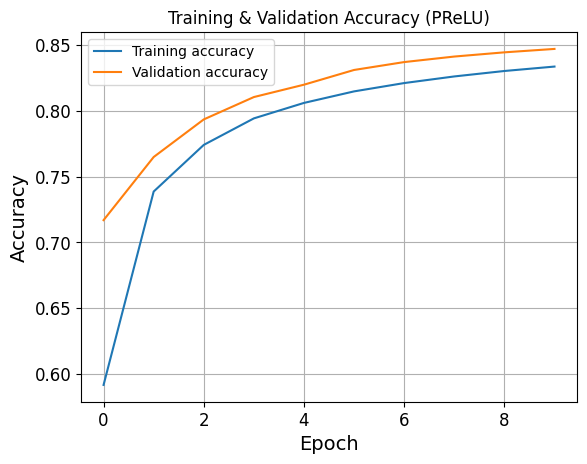

In [7]:
# Set seed
tf.random.set_seed(42)
np.random.seed(42)

# Bangun model dengan PReLU
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

# Compile & fit model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

# Ambil riwayat pelatihan
hist = history.history

# Tampilkan metrik akhir
print("=== Ringkasan Metrik Setelah 10 Epoch ===")
for m in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
    print(f"{m}: {hist[m][-1]:.4f}")

# Plot akurasi
plt.plot(hist['accuracy'], label='Training accuracy')
plt.plot(hist['val_accuracy'], label='Validation accuracy')
plt.title("Training & Validation Accuracy (PReLU)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### ELU

Saving figure elu_plot


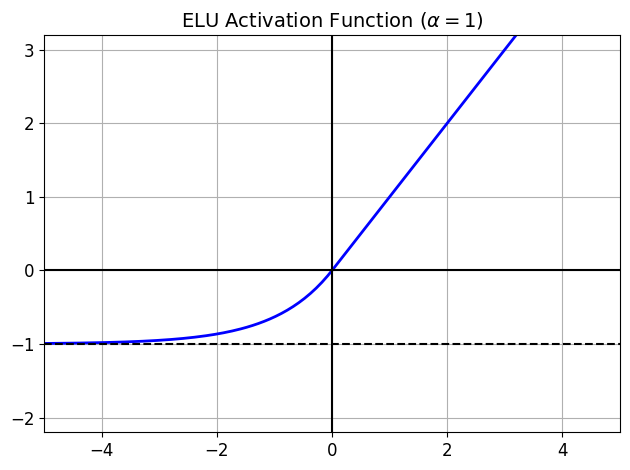

<Dense name=dense_8, built=False>

In [8]:
# Fungsi aktivasi ELU
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

# Plot fungsi ELU
z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU Activation Function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("elu_plot")
plt.show()

# Contoh layer Dense menggunakan ELU
keras.layers.Dense(10, activation="elu")

### SELU

Saving figure selu_plot


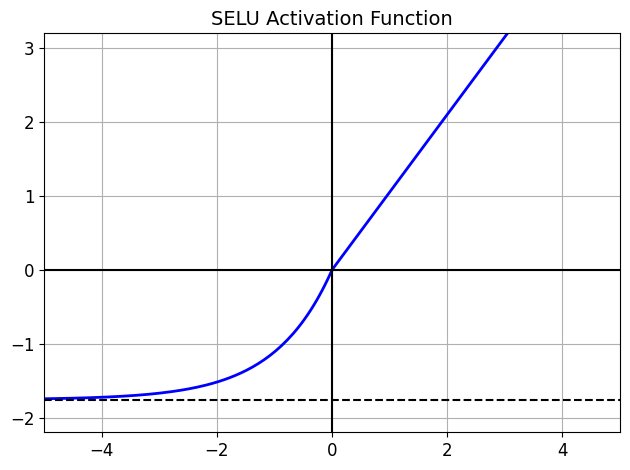

In [9]:
from scipy.special import erfc

# Hitung konstanta untuk self-normalizing
alpha_0_1 = -np.sqrt(2/np.pi) / (erfc(1/np.sqrt(2)) * np.exp(0.5) - 1)
scale_0_1 = (1 - erfc(1/np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * \
            (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e -
             2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-0.5)

# Definisi fungsi SELU
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

# Plot fungsi SELU
z = np.linspace(-5, 5, 200)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU Activation Function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("selu_plot")
plt.show()

In [10]:
# Standardisasi data
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model_selu = keras.models.Sequential()
model_selu.add(keras.layers.Flatten(input_shape=[28, 28]))
model_selu.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for _ in range(99):
    model_selu.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_selu.add(keras.layers.Dense(10, activation="softmax"))

model_selu.compile(loss="sparse_categorical_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                   metrics=["accuracy"])

history_selu = model_selu.fit(X_train_scaled, y_train, epochs=5,
                              validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.4414 - loss: 1.4706 - val_accuracy: 0.7216 - val_loss: 0.7815
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7279 - loss: 0.7329 - val_accuracy: 0.7494 - val_loss: 0.7081
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.7715 - loss: 0.6237 - val_accuracy: 0.7876 - val_loss: 0.6081
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8060 - loss: 0.5502 - val_accuracy: 0.8182 - val_loss: 0.5090
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8185 - loss: 0.5167 - val_accuracy: 0.8344 - val_loss: 0.4990


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model_relu = keras.models.Sequential()
model_relu.add(keras.layers.Flatten(input_shape=[28, 28]))
model_relu.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for _ in range(99):
    model_relu.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model_relu.add(keras.layers.Dense(10, activation="softmax"))

model_relu.compile(loss="sparse_categorical_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                   metrics=["accuracy"])

history_relu = model_relu.fit(X_train_scaled, y_train, epochs=5,
                              validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.1930 - loss: 2.0342 - val_accuracy: 0.2952 - val_loss: 1.8304
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.4014 - loss: 1.4296 - val_accuracy: 0.5346 - val_loss: 1.1086
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.5687 - loss: 1.0619 - val_accuracy: 0.5780 - val_loss: 1.0770
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5854 - loss: 1.0367 - val_accuracy: 0.6658 - val_loss: 0.9070
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.6218 - loss: 0.9308 - val_accuracy: 0.6742 - val_loss: 0.8549



=== Metrik Akhir SELU ===
accuracy: 0.8146
val_accuracy: 0.8344
loss: 0.5368
val_loss: 0.4990


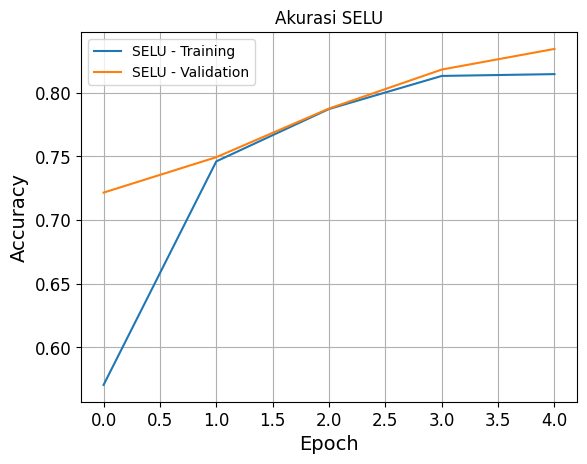


=== Metrik Akhir ReLU ===
accuracy: 0.6369
val_accuracy: 0.6742
loss: 0.9041
val_loss: 0.8549


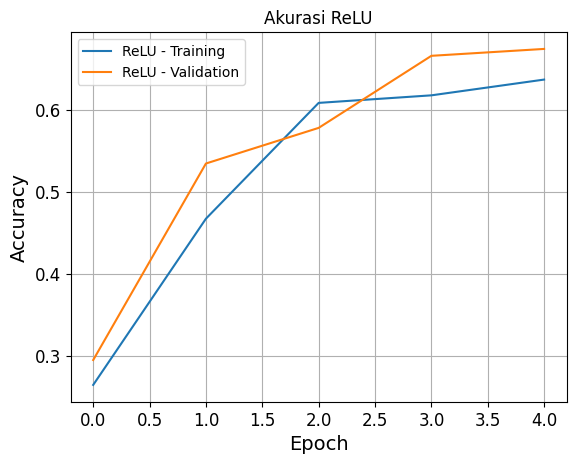

In [13]:
def show_metrics_plot(history, label="Model"):
    hist = history.history
    print(f"\n=== Metrik Akhir {label} ===")
    for m in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
        print(f"{m}: {hist[m][-1]:.4f}")

    plt.plot(hist['accuracy'], label=f'{label} - Training')
    plt.plot(hist['val_accuracy'], label=f'{label} - Validation')
    plt.title(f"Akurasi {label}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Tampilkan metrik dan plot
show_metrics_plot(history_selu, label="SELU")
show_metrics_plot(history_relu, label="ReLU")

## Batch Normalization

In [14]:
# Model 1: BatchNorm di antara Dense (bias aktif)
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model1.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

history1 = model1.fit(X_train, y_train, epochs=10,
                      validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6148 - loss: 1.1367 - val_accuracy: 0.8140 - val_loss: 0.5551
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7948 - loss: 0.5960 - val_accuracy: 0.8386 - val_loss: 0.4779
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8193 - loss: 0.5245 - val_accuracy: 0.8486 - val_loss: 0.4424
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8332 - loss: 0.4852 - val_accuracy: 0.8556 - val_loss: 0.4209
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8408 - loss: 0.4584 - val_accuracy: 0.8608 - val_loss: 0.4064
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8469 - loss: 0.4379 - val_accuracy: 0.8648 - val_loss: 0.3956
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8522 - loss: 0.4212 - val_accuracy: 0.8666 - val_loss: 0.3873
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8568 - loss: 0

In [15]:
# Model 2: BatchNorm dengan bias=False dan aktivasi dipisah
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model2.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

history2 = model2.fit(X_train, y_train, epochs=10,
                      validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5413 - loss: 1.4300 - val_accuracy: 0.7934 - val_loss: 0.6630
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7780 - loss: 0.7072 - val_accuracy: 0.8186 - val_loss: 0.5524
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8008 - loss: 0.6086 - val_accuracy: 0.8314 - val_loss: 0.5000
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8156 - loss: 0.5557 - val_accuracy: 0.8414 - val_loss: 0.4678
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8261 - loss: 0.5206 - val_accuracy: 0.8476 - val_loss: 0.4455
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8331 - loss: 0.4950 - val_accuracy: 0.8512 - val_loss: 0.4286
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8390 - loss: 0.4749 - val_accuracy: 0.8540 - val_loss: 0.4154
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8434 - loss: 0


=== Metrik Akhir Model 1 (BN + ReLU) ===
accuracy: 0.8674
val_accuracy: 0.8724
loss: 0.3784
val_loss: 0.3703


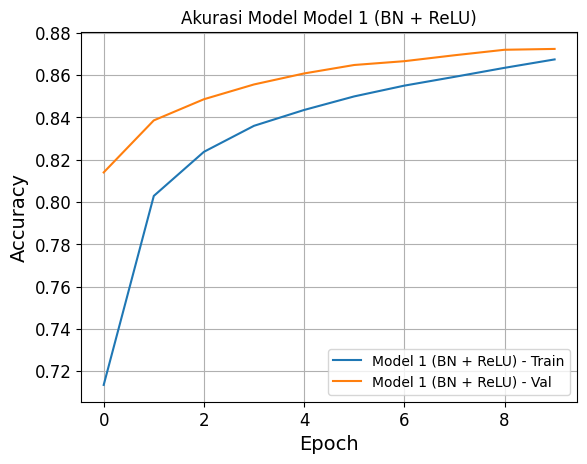


=== Metrik Akhir Model 2 (BN + No Bias + ReLU Separated) ===
accuracy: 0.8539
val_accuracy: 0.8594
loss: 0.4262
val_loss: 0.3882


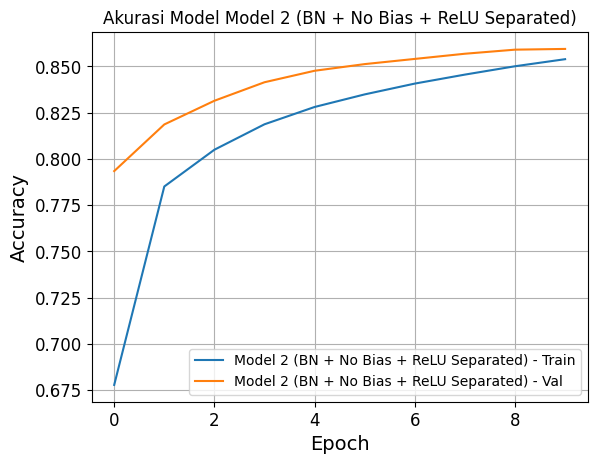

In [16]:
def show_metrics_plot(history, label):
    hist = history.history
    print(f"\n=== Metrik Akhir {label} ===")
    for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
        print(f"{key}: {hist[key][-1]:.4f}")
    plt.plot(hist['accuracy'], label=f'{label} - Train')
    plt.plot(hist['val_accuracy'], label=f'{label} - Val')
    plt.title(f"Akurasi Model {label}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

show_metrics_plot(history1, "Model 1 (BN + ReLU)")
show_metrics_plot(history2, "Model 2 (BN + No Bias + ReLU Separated)")

# **Eksperimen Batch Normalization dengan Fashion MNIST**

## Model 1: BatchNormalization + ReLU (bias aktif)
* BatchNormalization ditempatkan sebelum setiap lapisan Dense.

* Fungsi aktivasi ReLU digabungkan langsung di dalam lapisan Dense.

* Parameter bias tetap digunakan (use_bias=True, nilai default).

* Optimizer: SGD

* Loss Function: sparse_categorical_crossentropy

* Jumlah Epoch: 10

## Model 2: BatchNormalization + ReLU dipisah (bias nonaktif)
* Setiap lapisan Dense tidak menggunakan bias (use_bias=False) karena fungsinya digantikan oleh BatchNormalization.

* Fungsi aktivasi ReLU ditempatkan sebagai lapisan terpisah setelah BatchNormalization.

* Konfigurasi optimizer dan pelatihan sama dengan Model 1.

## Hasil Pelatihan (Epoch ke-10)
| **Metrik**       | **Model 1** (BN + ReLU) | **Model 2** (BN + No Bias + ReLU Terpisah) |
| ---------------- | ----------------------- | ------------------------------------------ |
| Akurasi          | 86,74%                  | 85,39%                                     |
| Akurasi Validasi | 87,24%                  | 85,94%                                     |
| Loss             | 0,3784                  | 0,4262                                     |
| Loss Validasi    | 0,3703                  | 0,3882                                    |

## Kesimpulan
* Kedua model menunjukkan performa yang sebanding, dengan akurasi validasi di atas 86%.

* Model 1 memiliki sedikit keunggulan dalam akurasi pelatihan.

* Model 2 menunjukkan kemampuan generalisasi yang lebih baik pada data validasi.

* Penggunaan BatchNormalization dengan aktivasi yang dipisah dari Dense tetap efektif dan tidak menurunkan performa.

* Batch Normalization tetap merupakan teknik yang kuat, baik ditempatkan sebelum maupun sesudah aktivasi, tergantung pada preferensi desain arsitektur jaringan.


